# Generic Data Loaders: or what to do when yt.load fails

*No frontend for your data?*

**Try a generic data loader!**

*Thinking about writing a new frontend?* 

**Try a generic data loader!** 

Gridded data? Yes! 

Particle Data? Yes! 

(with some caveats)

docs:
* loader api: https://yt-project.org/doc/reference/api/yt.loaders.html
* https://yt-project.org/doc/examining/Loading_Generic_Array_Data.html
* https://yt-project.org/doc/examining/Loading_Generic_Particle_Data.html

## structured grids:

* `load_uniform_grid`
* `load_amr_grids`
* `load_octree`
* `load_hdf5file`

## particles
* `load_particles`

## unstructured grids (finite element meshes)
* `load_unstructured_mesh`
* `load_hexahedral_mesh`

use some other package (`meshio`, others) to load connectivity, vertex coordinates and element data, coerce into form expected by yt. Detailed example here: https://github.com/chrishavlin/AGU2020/blob/main/notebooks/aspect_unstructured.ipynb) 

# loading SPH data with `load_particles`

1. Can you fit all your particles in memory?
2. Do you have only one SPH particle type?
3. Do you have `density`, `mass` and `smoothing_length` fields?

Then you can use `yt.load_particles` for your SPH data!

In [1]:
import numpy as np 
import yt 

data = {}

bbox = np.array([[np.inf, -np.inf], 
                [np.inf, -np.inf],
                [np.inf, -np.inf]])
n_part = int(1e4)

def _get_x_y_or_z(n_particles):
    x = np.arange(n_particles) / (n_particles ) 
    x = np.cos(x * np.pi * 2 / 10)
    return x + np.random.random((n_particles,)) * 0.2
    
data['io', 'particle_position_x'] = _get_x_y_or_z(n_part)
data['io', 'particle_position_y'] = _get_x_y_or_z(n_part)
data['io', 'particle_position_z'] = _get_x_y_or_z(n_part)

# for sph, need:
data['io', 'density'] =  (10**np.random.normal(loc=-28, scale=2, size=n_part), 'g/cm**3')
data['io', 'mass'] =  (10**np.random.normal(loc=38, scale=2, size=n_part), 'g')

smo = np.random.normal(loc=30, scale=10, size=n_part)
smo[smo<.5] = .5
data['io', 'smoothing_length'] = (smo, 'kpc')

# calculate a bbox
for idim, dim in enumerate('xyz'):
    bbox[idim][0] = min(bbox[idim][0], data['io', 'particle_position_'+dim].min())
    bbox[idim][1] = max(bbox[idim][1], data['io', 'particle_position_'+dim].max())

ds = yt.load_particles(data, length_unit='Mpc', bbox=bbox)

yt : [INFO     ] 2025-07-16 11:56:18,272 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-16 11:56:18,273 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-07-16 11:56:18,275 Parameters: domain_left_edge          = [0.81097409 0.81385171 0.81110845]
yt : [INFO     ] 2025-07-16 11:56:18,277 Parameters: domain_right_edge         = [1.19920438 1.19919295 1.1997657 ]
yt : [INFO     ] 2025-07-16 11:56:18,279 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2025-07-16 11:56:23,713 Allocating for 1e+04 particles
yt : [INFO     ] 2025-07-16 11:56:24,589 xlim = 0.810974 1.199204
yt : [INFO     ] 2025-07-16 11:56:24,590 ylim = 0.813852 1.199193
yt : [INFO     ] 2025-07-16 11:56:24,595 xlim = 0.810974 1.199204
yt : [INFO     ] 2025-07-16 11:56:24,597 ylim = 0.813852 1.199193
yt : [INFO     ] 2025-07-16 11:56:24,601 Making a fixed resolution buffer of (('io', 'density')) 800 by 800



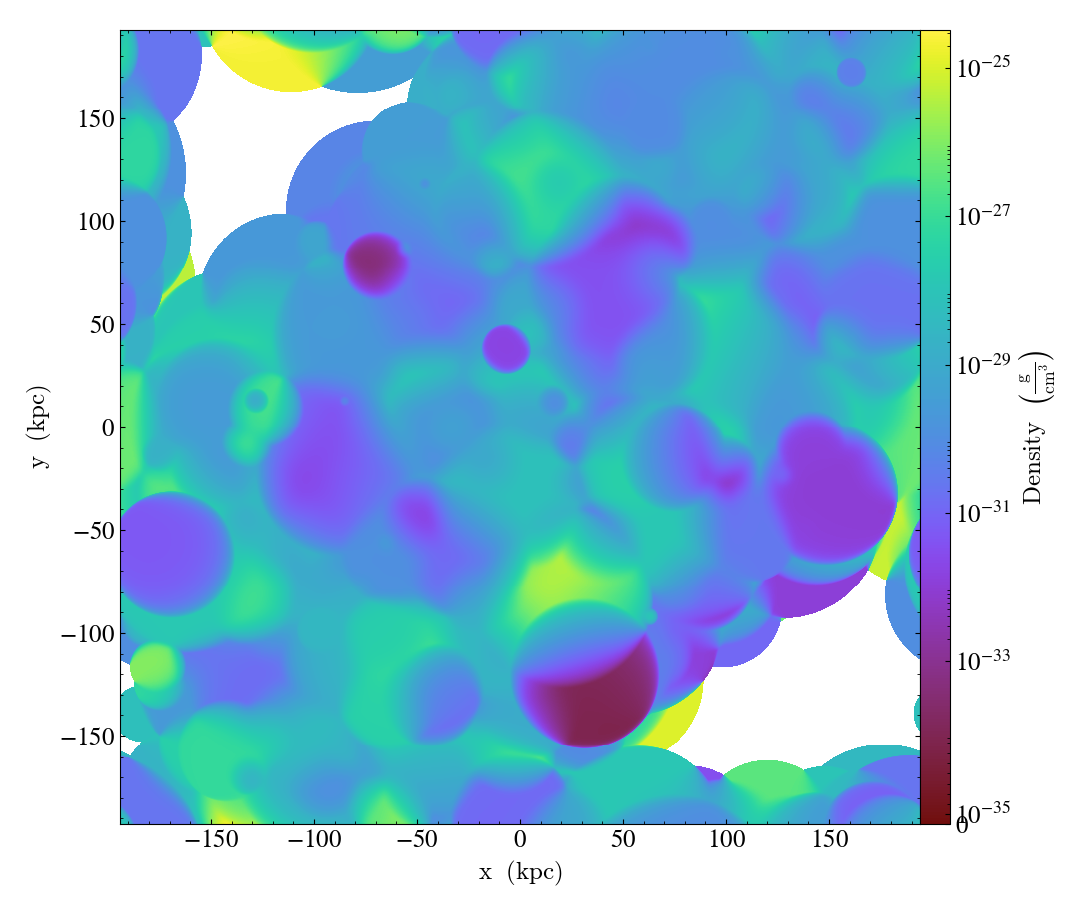

In [2]:
yt.SlicePlot(ds, 'z', ('io', 'density'))

yt : [INFO     ] 2025-07-16 11:56:33,936 xlim = -0.250000 0.250000
yt : [INFO     ] 2025-07-16 11:56:33,939 ylim = -0.250000 0.250000
yt : [INFO     ] 2025-07-16 11:56:33,940 zlim = -0.335543 0.335543
yt : [INFO     ] 2025-07-16 11:56:33,944 Making a fixed resolution buffer of (('io', 'density')) 800 by 800



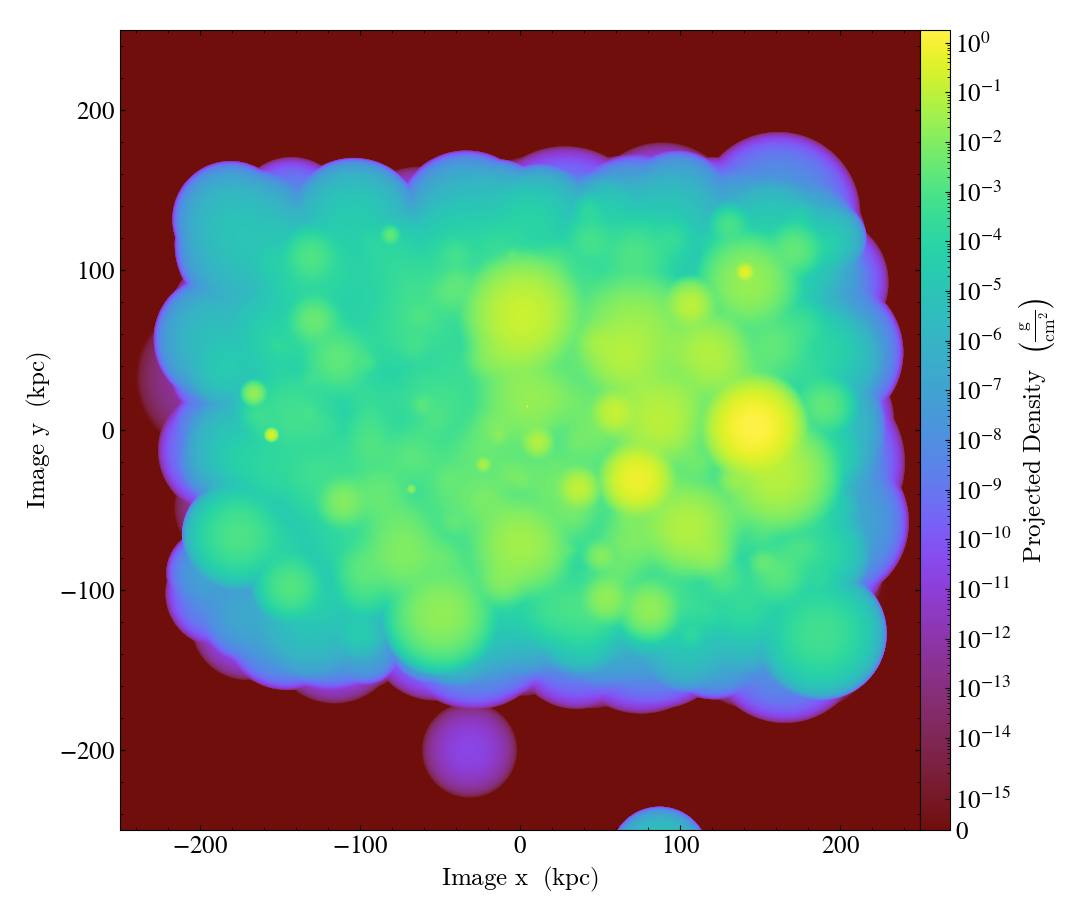

In [3]:
yt.ProjectionPlot(ds, (1., 1., 0), ('io', 'density'), width=(500, 'kpc'))

## `load_uniform_grid`


1. Do you have a single grid with cell-centered values?
2. Can you fit at least one field in memory?
3. Is your grid regular (uniform or stretched)?

uniform grid: $\Delta{x}, \Delta{y}, \Delta{z}$

![](solutions/figures/uniform_grid.png)

or 

stretched grid: $\Delta{x}(x), \Delta{y}(y), \Delta{z}(z)$:

![](solutions/figures/stretched_grid.png)

In [4]:
yt.load_uniform_grid?

Signature:
yt.load_uniform_grid(
    data,
    domain_dimensions,
    length_unit=None,
    bbox=None,
    nprocs=1,
    sim_time=0.0,
    mass_unit=None,
    time_unit=None,
    velocity_unit=None,
    magnetic_unit=None,
    periodicity=(True, True, True),
    geometry='cartesian',
    unit_system='cgs',
    default_species_fields=None,
    *,
    axis_order: tuple[str, str, str] | None = None,
    cell_widths=None,
    parameters=None,
    dataset_name: str = 'UniformGridData',
)
Docstring:
Load a uniform grid of data into yt as a
:class:`~yt.frontends.stream.data_structures.StreamHandler`.

This should allow a uniform grid of data to be loaded directly into yt and
analyzed as would any others.  This comes with several caveats:

* Units will be incorrect unless the unit system is explicitly
  specified.
* Some functions may behave oddly, and parallelism will be
  disappointing or non-existent in most cases.
* Particles may be difficult to integrate.

Particle fields are detected as 

yt : [INFO     ] 2025-07-16 12:00:08,999 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-16 12:00:09,001 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-07-16 12:00:09,003 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-16 12:00:09,006 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-16 12:00:09,009 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-07-16 12:00:09,237 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:00:09,239 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:00:09,245 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:00:09,246 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:00:09,251 Making a fixed resolution buffer of (('stream', 'field1')) 800 by 800



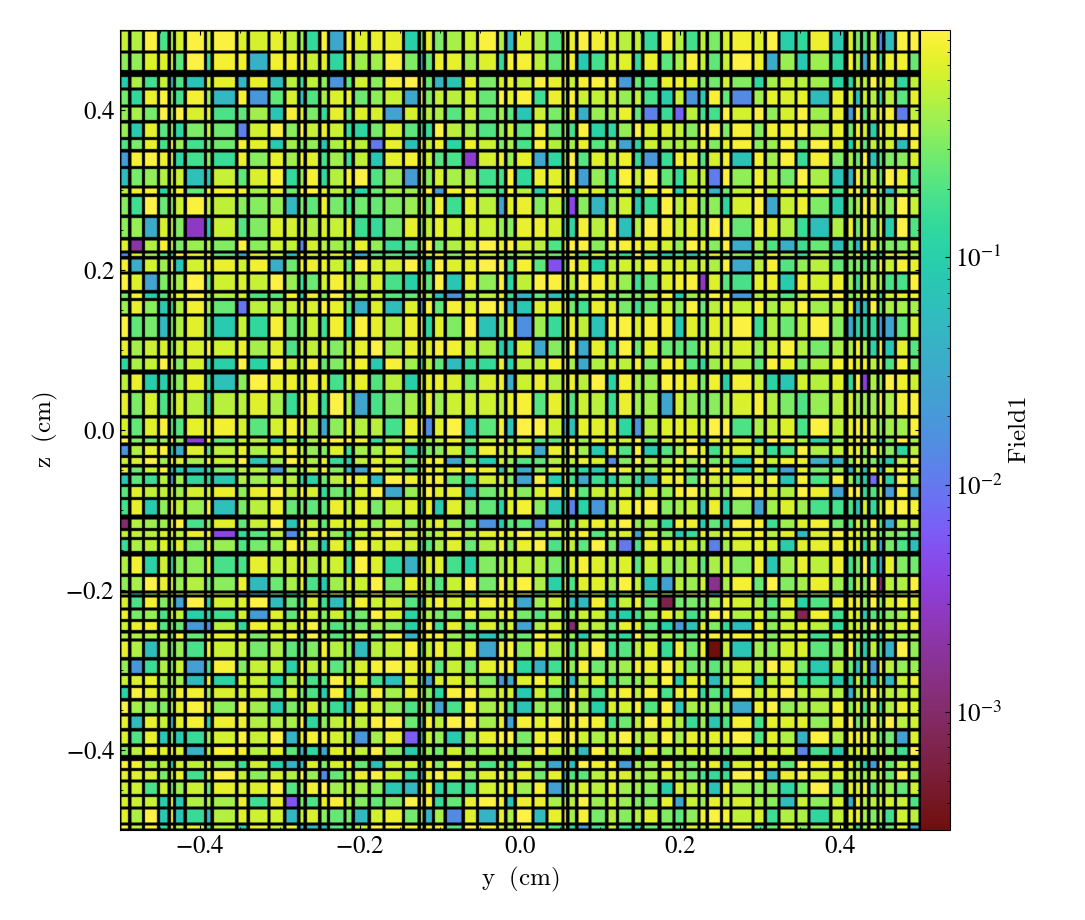

In [5]:
import yt 
import numpy as np
shp = (64, 64, 64)

cell_widths = [
    np.random.normal(loc=10, scale = 5, size=shp[0]),
    np.random.normal(loc=10, scale = 5, size=shp[1]),
    np.random.normal(loc=10, scale = 5, size=shp[2]),
]

# make them sum to 1
for dim, cw in enumerate(cell_widths):
    cw[cw<.1] = .1  # make sure we have > 0
    cell_widths[dim] = cw / np.sum(cw)
    
    
data = {
    'field1': np.random.random(shp),
}
ds = yt.load_uniform_grid(data, shp, cell_widths=cell_widths)

slc = yt.SlicePlot(ds, 'x', ('stream', 'field1'))
slc.annotate_cell_edges()
slc

yt : [INFO     ] 2025-07-16 12:00:46,763 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-16 12:00:46,764 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-07-16 12:00:46,766 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-16 12:00:46,768 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-16 12:00:46,769 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-07-16 12:00:46,987 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:00:46,989 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:00:46,997 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:00:46,998 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:00:47,003 Making a fixed resolution buffer of (('stream', 'field1')) 800 by 800


there are this many grids 8


/home/chavlin/.pyenv/versions/3.10.18/envs/yt-workshop/lib/python3.10/site-packages/unyt/array.py:1972: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
/home/chavlin/.pyenv/versions/3.10.18/envs/yt-workshop/lib/python3.10/site-packages/yt/visualization/image_writer.py:269: RuntimeWarning: invalid value encountered in cast
  mapped = np.dstack([(np.interp(buff, x, v) * 255).astype("uint8") for v in lut])



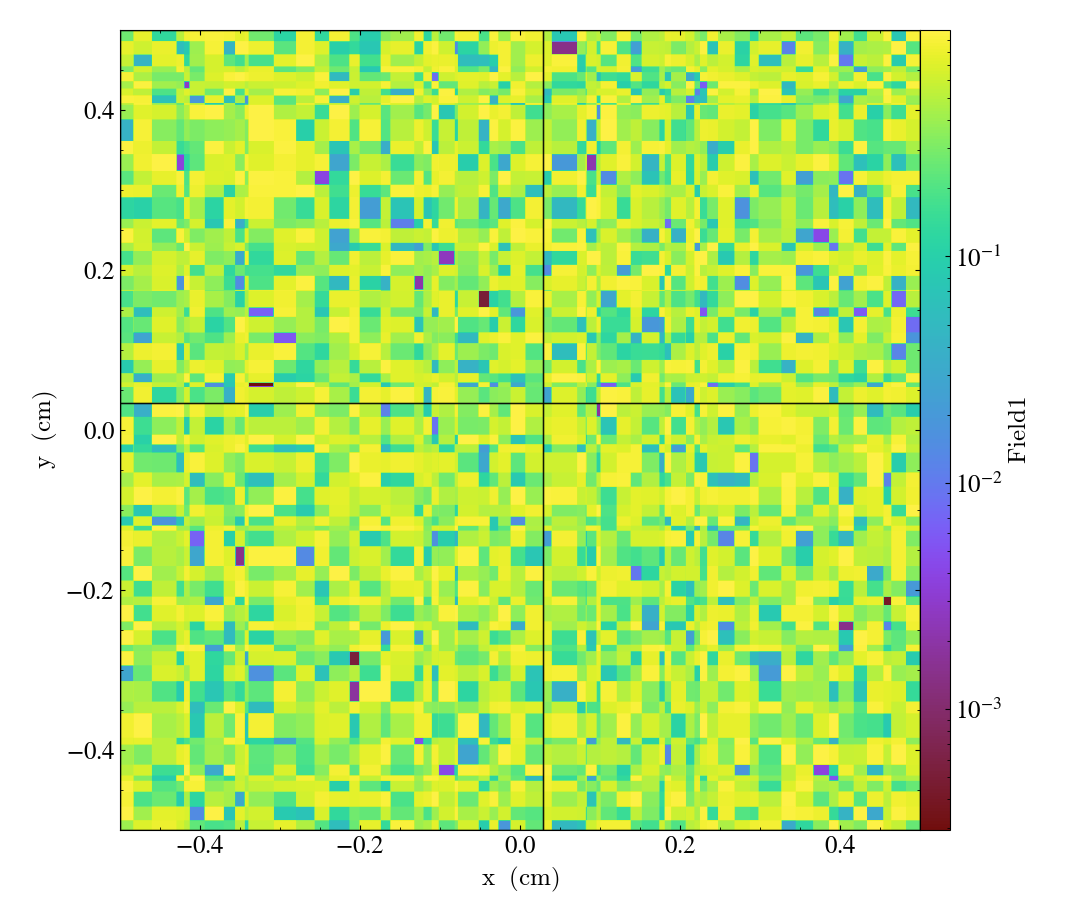

In [6]:
ds_nproc = yt.load_uniform_grid(data, shp, 
                                cell_widths=cell_widths, 
                                nprocs=8)

print(f"there are this many grids {ds_nproc.index.num_grids}")

slc = yt.SlicePlot(ds_nproc, 'z', ('stream', 'field1'))
slc.annotate_grids()
slc

multiple grids, but base data is still in memory :( 

## Loading from functions

If you read the whole docstring for `load_uniform_grids`, maybe you caught the entry for the `data` argument:

```
data : dict
    This is a dict of numpy arrays, (numpy array, unit spec) tuples.
    Functions may also be supplied in place of numpy arrays as long as the
    subsequent argument nprocs is not specified to be greater than 1.
    Supplied functions much accepts the arguments (grid_object, field_name)
    and return numpy arrays.  The keys to the dict are the field names.
```


This bit: **`Functions may also be supplied in place of numpy arrays`** is powerful! 


What's that mean?


Instead of 

```python
data = {
    'field1': np.random.random(shp),
}
``` 

you can do supply a function and do **anything you want**  (almost):

```python
data = {
    'field1': read_data_from_a_file_or_something,
}
```

as long as `read_data_from_a_file_or_something` conforms to some rules... 

[yt_xarray](https://yt-xarray.readthedocs.io/) in 7 lines:

```python

import xarray as xr 
import yt 

ds_xr = open_dataset(....) 

def read_data_from_a_file_or_something(grid_object, field_tuple):
    return interpolate_xr_ds_to_grid_object(ds_xr, grid_object, field_tuple)

yt_ds = yt.load_uniform_grid({'field1': read_data_from_a_file_or_something}, nprocs = 8)

```

where `grid_object` is a grid:


In [9]:
ds_nproc.index.grids[1]

StreamStretchedGrid_0001 ([32 32 32])

In [10]:
ds_nproc.index.grids[0].LeftEdge, ds_nproc.index.grids[0].RightEdge, ds_nproc.index.grids[0].shape

(unyt_array([0., 0., 0.], 'code_length'),
 unyt_array([0.52932498, 0.53386409, 0.44500126], 'code_length'),
 array([32, 32, 32], dtype=int32))

In [ ]:
g0 = ds.index.grids[0]
g0

from which we can extract the extent and shape of that grid:

In [ ]:
g0.LeftEdge, g0.RightEdge, g0.shape

ok, so let's think about the `field_tuple` argument a bit too. This will be actually be a tuple of field type and field name:

```python
field_tuple = (field_type, actual_field_name)
```

there are some slightly finicky behaviors related to field types and the generic data loaders... most will end up with a field type called `'stream'`, and due to **reasons**, we can't use the raw field types from our primary dataset. So what we'll do in our function is replace the incoming `'stream'` fieldtype with `'enzo'` in our function:


```python
def load_field_from_ag(grid_object, field_tuple):

    # get the extent and shape of the grid_object
    le = # left edge of the grid object
    re = # right edge of the grid object
    shape = # shape of the grid object 

    # construct an abritrary grid on the **full** dataset
    ag = ds.arbitrary_grid(le, re, shape)

    # evaluate the field on the arbitrary grid of the full dataset 
    ds_field_tuple = ('enzo', field_tuple[1])
    fixed_res_array = ag[ds_field_tuple].d  # make it a plain numpy array with the .d
    return fixed_res_array
```    

Ooooook, we are ready:

In [ ]:
def load_field_from_ag(grid_object, field_name):
    # get the extent and shape of the grid_object
    le = grid_object.LeftEdge  # left edge of the grid object
    re = grid_object.RightEdge # right edge of the grid object 
    shape = grid_object.shape # shape of the grid object 

    # construct an abritrary grid on the **full** dataset    
    ag = ds.arbitrary_grid(le, re, shape)

    # evaluate the field on the arbitrary grid of the full dataset 
    # full_ds_field_name = field_name_map[field_name[1]]  # annoying.    
    full_ds_field_name = ('enzo', field_name[1]) # replace     
    fixed_res_array = ag[full_ds_field_name].d  # make it a plain numpy array with the .d
    return fixed_res_array

and let's build our field dictionary, keeping only the `'enzo'` field type fields:

In [ ]:
data = {}

for field in ds.field_list:    
    if field[0] == 'enzo':
        data[field[1]] = load_field_from_ag

data.keys()

In [ ]:
arbitrary_shape = (256, 256, 256)
arbitrary_bbox = np.array([[.48, .52], 
                           [.48, .52],
                           [.48, .52]])

ds_delayed = yt.load_uniform_grid(data, arbitrary_shape, bbox=arbitrary_bbox, length_unit='Mpc')

In [ ]:
ds_delayed.field_list

In [ ]:
yt.SlicePlot(ds_delayed, 'z', ('stream', 'Density'), origin='native')

In [ ]:
yt.SlicePlot(ds_delayed, 'z', ('stream', 'Density'), origin='native')

In [ ]:
yt.SlicePlot(ds_delayed, 'z', ('stream', 'Temperature'), origin='native')

Ok... but why??

The `ds` reference in:

```python
def load_field_from_ag(grid_object, field_name):

    # grid_object is for the wrapping dataset
    le = ds.arr(grid_object.LeftEdge.to('kpc').d, 'kpc')
    re = ds.arr(grid_object.RightEdge.to('kpc').d, 'kpc')
    shape = grid_object.shape

    
    ag = ds.arbitrary_grid(le, re, shape)

    print(le, re, shape)
    
    return ag[field_name_map[field_name[1]]].d
```

Could be anything! 

* handle to an open h5py file (`yt.load_hdf5_file`)
* handle to an open xarray dataset (`yt_xarray`)
* a dask array
* a zarr store
* ......

`load_amr_grids` **also accepts functions** for loading, so you can, e.g., map chunks of a dask or zarr array to yt grid objects to handle larger-than-memory datasets.

## `load_amr_grids` 

Like `load_uniform_grid` but more flexible! 

Instead of `data`, you give it a list of `grids`:

```python
grid = {
        "left_edge": le_i,
        "right_edge": re_i,
        "dimensions": sz_i,
        "level": lev,
        ("stream", "density"): levp1_noisy,
        ("stream", "lev_p1"): levp1,
    }
```

* `left_edge` and `right_edge`: the 3D left/right corners of the grid
* `dimensions`: the shape of the grid
* `level`: the refinement level
* `("stream", "density")` and `("stream", "lev_p1")` some data fields so we can plot


In [11]:
# set our global bounding box
bbox = np.array([[-1., 1.], 
                 [-1., 1.], 
                 [-1., 1.]])

# size of the coarsest grid (level 0)
sz_0 = np.array((64, 64, 64))

# max refinement levels
max_lev = 4

# calculate box width, box center, grid spacing for level 0
bbox_wid = bbox[:, 1] - bbox[:, 0]
bbox_c = np.mean(bbox, axis=1)
dd0 = bbox_wid / sz_0

# iterate over grid levels
sz_i = sz_0.copy()
grids = []  # container for each grid dictionary
for lev in range(max_lev):

    # calculate the current grid's bounding box width
    box_wid_factor = 2.0 * int(lev > 0) + int(lev == 0) * 1.0
    bbox_wid = bbox_wid / box_wid_factor

    # calculate the left/right edges
    le_i = bbox_c - bbox_wid / 2.0
    re_i = bbox_c + bbox_wid / 2.0

    # find closest start/end index in lev 0 grid
    start_i = np.round(le_i / dd0).astype(int)
    end_i = np.round(re_i / dd0).astype(int)
    sz_0 = end_i - start_i

    # recompute for rounding errors (watch out!)
    le_i = start_i * dd0
    re_i = le_i + sz_0 * dd0

    # the size of the current level
    sz_i = sz_0 * 2**lev

    # calculate some fields for this level
    levp1 = np.full(sz_i, lev + 1.0)
    levp1_noisy = levp1 + np.random.random(sz_i) - 0.5

    # define the grid dictionary
    grid = {
        "left_edge": le_i,
        "right_edge": re_i,
        "dimensions": sz_i,
        "level": lev,
        ("stream", "lev_p1_noisy"): levp1_noisy,
        ("stream", "lev_p1"): levp1,
    }
    grids.append(grid)

ds = yt.load_amr_grids(
    grids,
    sz_0,
    bbox=bbox,
    length_unit='m',    
)

yt : [INFO     ] 2025-07-16 12:06:48,512 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-16 12:06:48,513 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2025-07-16 12:06:48,515 Parameters: domain_left_edge          = [-1. -1. -1.]
yt : [INFO     ] 2025-07-16 12:06:48,516 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-16 12:06:48,518 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2025-07-16 12:07:59,676 xlim = -1.000000 1.000000
yt : [INFO     ] 2025-07-16 12:07:59,677 ylim = -1.000000 1.000000
yt : [INFO     ] 2025-07-16 12:07:59,687 xlim = -1.000000 1.000000
yt : [INFO     ] 2025-07-16 12:07:59,689 ylim = -1.000000 1.000000
yt : [INFO     ] 2025-07-16 12:07:59,695 Making a fixed resolution buffer of (('stream', 'lev_p1_noisy')) 800 by 800



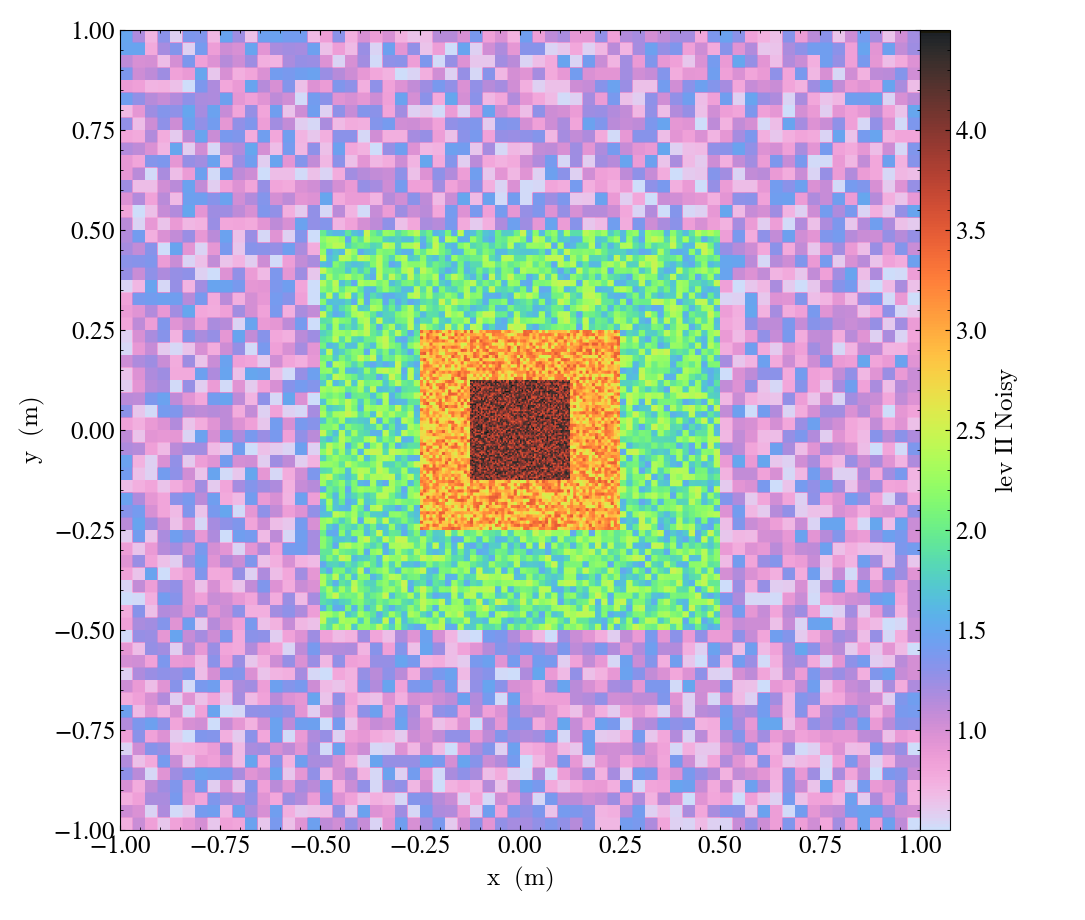

In [12]:
slc = yt.SlicePlot(ds, 'z', ('stream', 'lev_p1_noisy'))
slc.set_log(('stream', 'lev_p1_noisy'), False)
slc.set_cmap(('stream', 'lev_p1_noisy'), 'cmyt.pastel_r')
slc


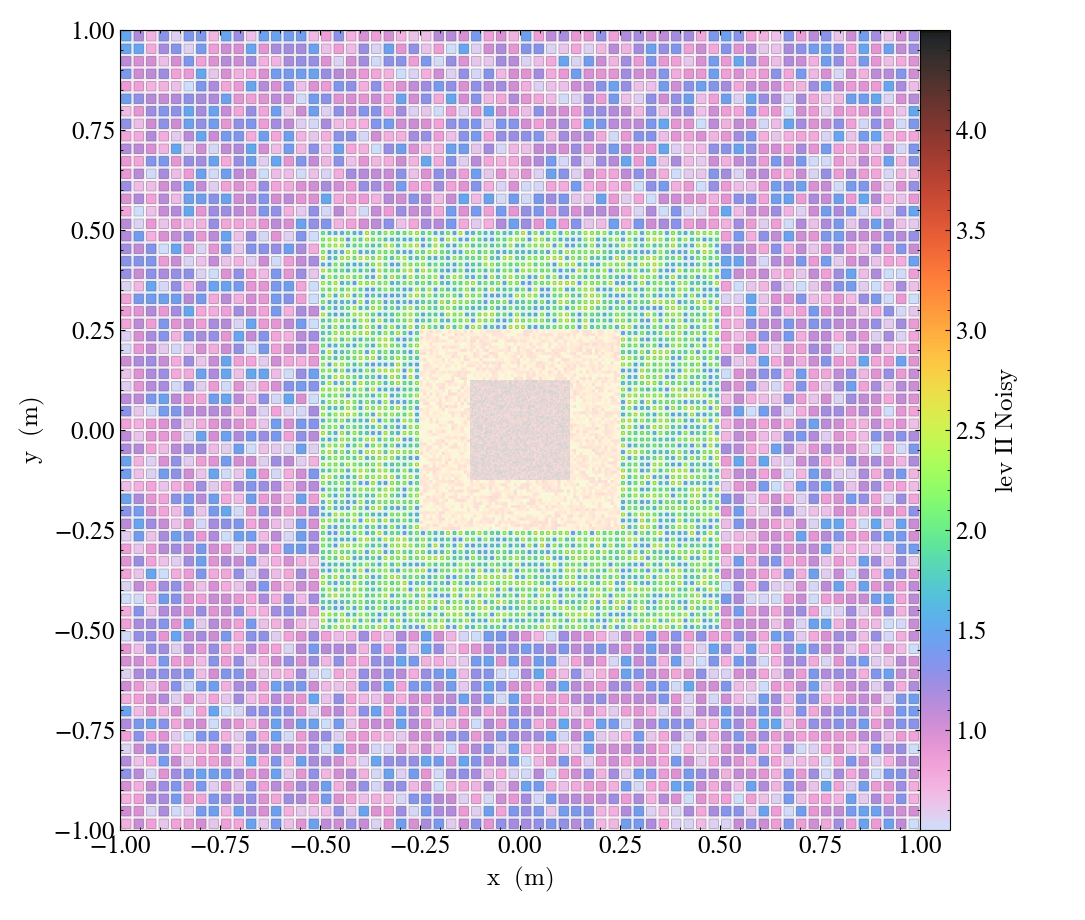

In [13]:
slc.annotate_cell_edges(color=(1., 1., 1.), alpha= 0.8)
slc


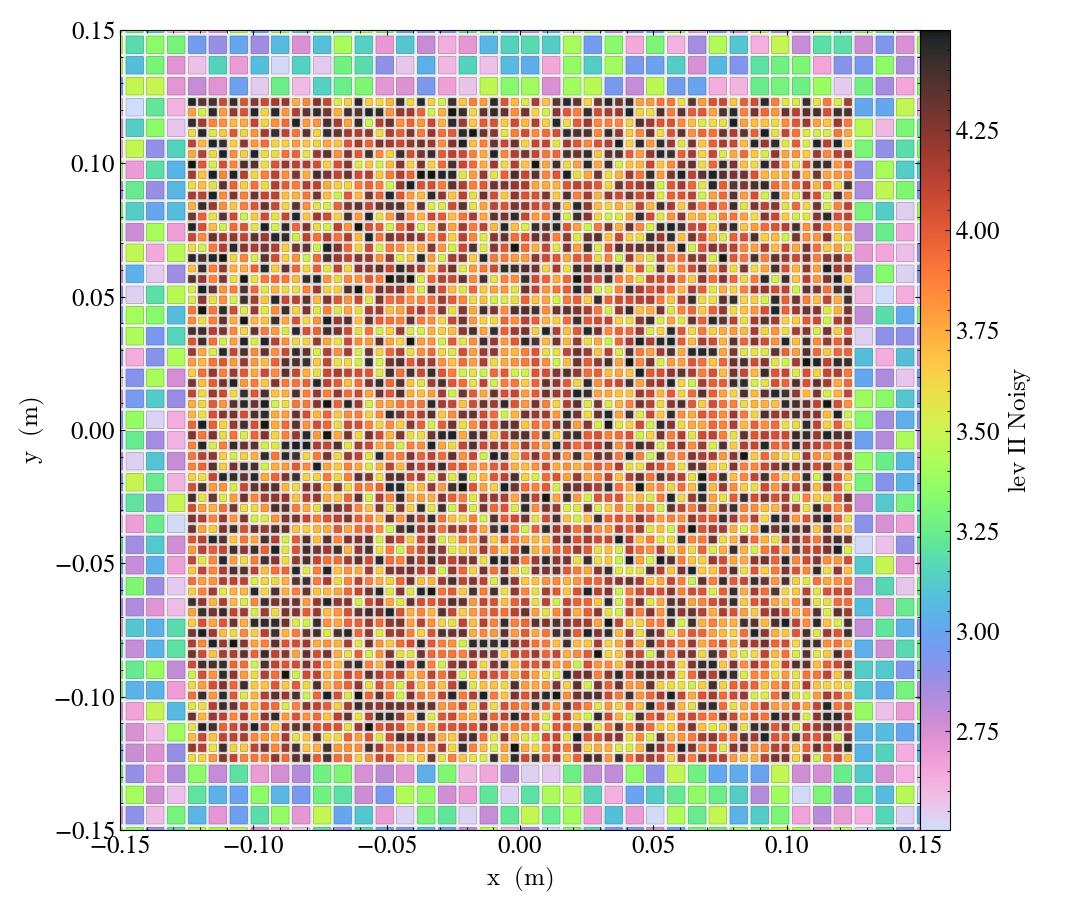

In [14]:
slc.set_width(0.3, 'm')

### remember our loading from functions?

```python
    grid = {
        "left_edge": le_i,
        "right_edge": re_i,
        "dimensions": sz_i,
        "level": lev,
        ("stream", "lev_p1_noisy"): levp1_noisy,
        ("stream", "lev_p1"): levp1,
    }
```

**COULD BE**

```python
    grid = {
        "left_edge": le_i,
        "right_edge": re_i,
        "dimensions": sz_i,
        "level": lev,
        ("stream", "lev_p1_noisy"): load_from_file,
        ("stream", "lev_p1"): load_from_file,
    }
```    

where `load_from_file` is a function handle for loading a field from a file.

Lazy evaluation! By grid!! 


### `load_hdf5_file`

`load_amr_grids` + loading from function


(512, 512, 512)


yt : [INFO     ] 2025-07-16 12:11:00,927 Assuming unitary (0..1) bounding box.
yt : [INFO     ] 2025-07-16 12:11:00,931 Auto-guessing 512 chunks from a size of 134217728
yt : [INFO     ] 2025-07-16 12:11:01,214 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-16 12:11:01,216 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2025-07-16 12:11:01,217 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-16 12:11:01,219 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-16 12:11:01,223 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-07-16 12:11:02,939 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:11:02,943 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:11:02,952 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:11:02,955 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-07-16 12:11:02,963 Making a fixed resolution buffer of (('stream', 'density')) 800 by 800
/home/c


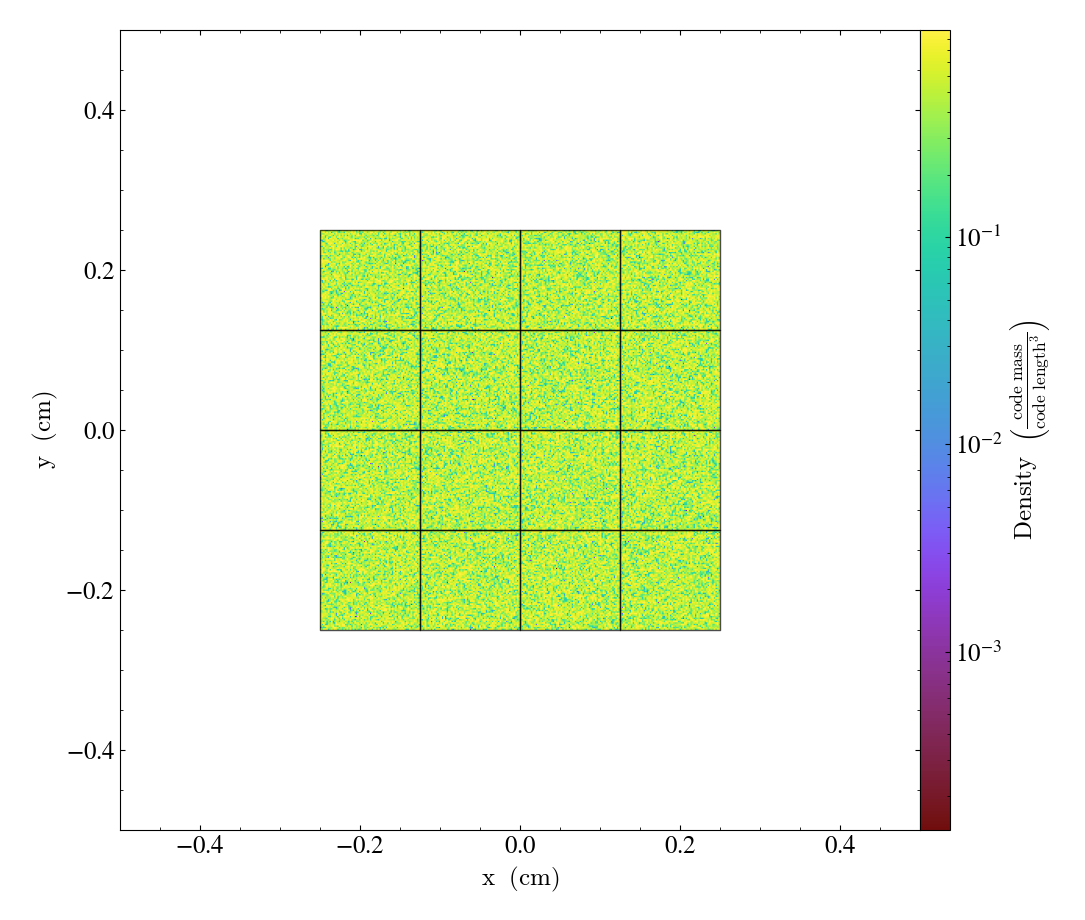

In [15]:
import h5py 
import os 
import numpy as np 
import yt
my_file = 'hello.h5'
if os.path.isfile(my_file):
    os.remove(my_file)

    
with h5py.File(my_file, 'w') as ds_h5:
    ds_h5.create_group('cooldata')
    values = np.random.random((512, 512, 512))
    print(values.shape)
    ds_h5['cooldata'].create_dataset('density', data=values, dtype=np.float64)


ds_h5 = yt.load_hdf5_file(my_file, root_node='cooldata')  # nchunks = 


reg = ds_h5.region(ds_h5.domain_center, 
                  ds_h5.domain_center - ds_h5.domain_width/4, 
                  ds_h5.domain_center + ds_h5.domain_width/4)
slc = yt.SlicePlot(ds_h5, 'z', ('stream', 'density'), data_source=reg)
slc.annotate_grids()
slc